In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mpl_finance as mplf
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import Risk_Ratio_Functions
import time
import tushare as ts

In [2]:
# 打开Tushare链接
cons = ts.get_apis()

In [3]:
stadate = '2018-06-14'
Now_Date = time.strftime('%Y-%m-%d',time.localtime(time.time()))
enddate = pd.to_datetime(Now_Date)

In [4]:
# 输入Stock_data，并处理索引、日期格式、按索引日期排序
# Stock_data = ts.bar('510300', conn=cons)
# Stock_data['date'] = Stock_data.index
# Stock_data['volume'] = Stock_data['vol']*100
Stock_data = pd.read_csv('510300.csv')
Stock_data = Stock_data.set_index('date')
Stock_data.index = pd.to_datetime(Stock_data.index)
Stock_data = Stock_data.sort_index(axis=0, ascending=True)

In [5]:
Stock_data.tail()

,open,high,low,close,volume
date,,,,,
2018-09-17,3.285,3.291,3.264,3.272,115650816
2018-09-18,3.261,3.339,3.260,3.335,236746848
2018-09-19,3.330,3.407,3.323,3.380,446329248
2018-09-20,3.380,3.413,3.371,3.378,244090448
2018-09-21,3.388,3.486,3.377,3.484,477366016


In [6]:
# 风险决策指标
Risk_Ratio = Risk_Ratio_Functions.Risk_Ratio(Stock_data)
Risk_Ratio = Risk_Ratio[['Decision','MAJCQX']]

In [7]:
Risk_Ratio.tail()

,Decision,MAJCQX
date,,
2018-09-17,34,32.186667
2018-09-18,40.8,34.453333
2018-09-19,63.92,46.240000
2018-09-20,55.76,53.493333
2018-09-21,70.72,63.466667


In [8]:
# 运筹帷幄指标，指标构建
DA = 6
ZFXF_YCWW = pd.DataFrame()
ZFXF_YCWW['LLV_min'] = Stock_data['close'].rolling(window=DA).min()
ZFXF_YCWW['HHV_max'] = Stock_data['close'].rolling(window=DA).max()
ZFXF_YCWW['ABS'] = np.abs(ZFXF_YCWW['HHV_max']/ZFXF_YCWW['LLV_min']-1)
ZFXF_YCWW['MAX'] = ZFXF_YCWW['ABS'].rolling(window=DA).max()
ZFXF_YCWW['DA'] = DA
ZFXF_YCWW.loc[ZFXF_YCWW['MAX']>0.1,'DA'] = 3
ZFXF_YCWW['Tomorrow'] = Stock_data['close'].rolling(window=DA).mean()
ZFXF_YCWW.loc[ZFXF_YCWW['DA'] == 3,'Tomorrow'] = Stock_data['close'].rolling(window=3).mean()
ZFXF_YCWW['YCWW'] = ZFXF_YCWW['Tomorrow'].shift(1)

In [9]:
ZFXF_YCWW.tail()

,LLV_min,HHV_max,ABS,MAX,DA,Tomorrow,YCWW
date,,,,,,,
2018-09-17,3.263,3.303,0.012259,0.041692,6,3.286667,3.299000
2018-09-18,3.263,3.335,0.022066,0.041692,6,3.292833,3.286667
2018-09-19,3.263,3.380,0.035857,0.035857,6,3.308500,3.292833
2018-09-20,3.272,3.380,0.033007,0.035857,6,3.327667,3.308500
2018-09-21,3.272,3.484,0.064792,0.064792,6,3.358667,3.327667


In [10]:
# 运筹帷幄指标，买卖信号点构建
ZFXF_YCWW['Buy_point'] = 0
ZFXF_YCWW.loc[Stock_data['close'] > ZFXF_YCWW['YCWW'],'Buy_point'] = 1
ZFXF_YCWW['Sell_point'] = 0
ZFXF_YCWW.loc[Stock_data['close'] < ZFXF_YCWW['YCWW'],'Sell_point'] = -1
ZFXF_YCWW['Points'] = ZFXF_YCWW['Buy_point']+ZFXF_YCWW['Sell_point']

In [11]:
# 运筹帷幄指标，形成【成住坏空（2，1，-2，-1）】信号点
g = len(ZFXF_YCWW)
ZFXF_YCWW['order'] = np.arange(0,g,1)
ZFXF_YCWW.loc[g-1:g,'Points'] = -1
ZFXF_YCWW['BS_point'] = ZFXF_YCWW['Points'].shift(1)
ZFXF_YCWW['BS_point'] = ZFXF_YCWW['BS_point'].fillna(-1)
ZFXF_YCWW['BS_point'] = (ZFXF_YCWW['Points'] - ZFXF_YCWW['BS_point'])/2+ZFXF_YCWW['Points']

In [12]:
ZFXF_YCWW.tail()

,LLV_min,HHV_max,ABS,MAX,DA,Tomorrow,YCWW,Buy_point,Sell_point,Points,order,BS_point
date,,,,,,,,,,,,
2018-09-17,3.263,3.303,0.012259,0.041692,6,3.286667,3.299000,0,-1,-1,1539,-2.0
2018-09-18,3.263,3.335,0.022066,0.041692,6,3.292833,3.286667,1,0,1,1540,2.0
2018-09-19,3.263,3.380,0.035857,0.035857,6,3.308500,3.292833,1,0,1,1541,1.0
2018-09-20,3.272,3.380,0.033007,0.035857,6,3.327667,3.308500,1,0,1,1542,1.0
2018-09-21,3.272,3.484,0.064792,0.064792,6,3.358667,3.327667,1,0,-1,1543,-2.0


In [13]:
# 合并两大指标
Stock_Risk_Ratio_ZFXF_YCWW = pd.concat([Stock_data,Risk_Ratio,ZFXF_YCWW[['YCWW','Tomorrow','BS_point']]], axis=1)
Stock_Risk_Ratio_ZFXF_YCWW.tail()

,open,high,low,close,volume,Decision,MAJCQX,YCWW,Tomorrow,BS_point
date,,,,,,,,,,
2018-09-17,3.285,3.291,3.264,3.272,115650816,34,32.186667,3.299000,3.286667,-2.0
2018-09-18,3.261,3.339,3.260,3.335,236746848,40.8,34.453333,3.286667,3.292833,2.0
2018-09-19,3.330,3.407,3.323,3.380,446329248,63.92,46.240000,3.292833,3.308500,1.0
2018-09-20,3.380,3.413,3.371,3.378,244090448,55.76,53.493333,3.308500,3.327667,1.0
2018-09-21,3.388,3.486,3.377,3.484,477366016,70.72,63.466667,3.327667,3.358667,-2.0


In [14]:
# BOLL轨道
Nb = 20
M = 2
Stock_Risk_Ratio_ZFXF_YCWW['MB'] = Stock_Risk_Ratio_ZFXF_YCWW['close'].rolling(window=Nb).mean()
Stock_Risk_Ratio_ZFXF_YCWW['MD'] = Stock_Risk_Ratio_ZFXF_YCWW['close'].rolling(window=Nb).std()
Stock_Risk_Ratio_ZFXF_YCWW['UP'] = Stock_Risk_Ratio_ZFXF_YCWW['MB'] + 2 * Stock_Risk_Ratio_ZFXF_YCWW['MD']
Stock_Risk_Ratio_ZFXF_YCWW['DN'] = Stock_Risk_Ratio_ZFXF_YCWW['MB'] - 2 * Stock_Risk_Ratio_ZFXF_YCWW['MD']

In [15]:
Stock_Risk_Ratio_ZFXF_YCWW.tail()

,open,high,low,close,volume,Decision,MAJCQX,YCWW,Tomorrow,BS_point,MB,MD,UP,DN
date,,,,,,,,,,,,,,
2018-09-17,3.285,3.291,3.264,3.272,115650816,34,32.186667,3.299000,3.286667,-2.0,3.36320,0.063560,3.490320,3.236080
2018-09-18,3.261,3.339,3.260,3.335,236746848,40.8,34.453333,3.286667,3.292833,2.0,3.36100,0.063745,3.488491,3.233509
2018-09-19,3.330,3.407,3.323,3.380,446329248,63.92,46.240000,3.292833,3.308500,1.0,3.36135,0.063834,3.489018,3.233682
2018-09-20,3.380,3.413,3.371,3.378,244090448,55.76,53.493333,3.308500,3.327667,1.0,3.36110,0.063754,3.488609,3.233591
2018-09-21,3.388,3.486,3.377,3.484,477366016,70.72,63.466667,3.327667,3.358667,-2.0,3.36590,0.069262,3.504424,3.227376


In [16]:
# ENE轨道
Ne = 10
M1 = 11
M2 = 9
Stock_Risk_Ratio_ZFXF_YCWW['MA'] = Stock_Risk_Ratio_ZFXF_YCWW['close'].rolling(window=Ne).mean()
Stock_Risk_Ratio_ZFXF_YCWW['UPPER'] = (1.0+M1/100.0) * Stock_Risk_Ratio_ZFXF_YCWW['MA']
Stock_Risk_Ratio_ZFXF_YCWW['LOWER'] = (1.0-M2/100.0) * Stock_Risk_Ratio_ZFXF_YCWW['MA']
Stock_Risk_Ratio_ZFXF_YCWW['ULENE'] = (Stock_Risk_Ratio_ZFXF_YCWW['UPPER'] + Stock_Risk_Ratio_ZFXF_YCWW['LOWER'])/2

In [17]:
Stock_Risk_Ratio_ZFXF_YCWW.tail()

,open,high,low,close,volume,Decision,MAJCQX,YCWW,Tomorrow,BS_point,MB,MD,UP,DN,MA,UPPER,LOWER,ULENE
date,,,,,,,,,,,,,,,,,,
2018-09-17,3.285,3.291,3.264,3.272,115650816,34,32.186667,3.299000,3.286667,-2.0,3.36320,0.063560,3.490320,3.236080,3.3166,3.681426,3.018106,3.349766
2018-09-18,3.261,3.339,3.260,3.335,236746848,40.8,34.453333,3.286667,3.292833,2.0,3.36100,0.063745,3.488491,3.233509,3.3078,3.671658,3.010098,3.340878
2018-09-19,3.330,3.407,3.323,3.380,446329248,63.92,46.240000,3.292833,3.308500,1.0,3.36135,0.063834,3.489018,3.233682,3.3105,3.674655,3.012555,3.343605
2018-09-20,3.380,3.413,3.371,3.378,244090448,55.76,53.493333,3.308500,3.327667,1.0,3.36110,0.063754,3.488609,3.233591,3.3159,3.680649,3.017469,3.349059
2018-09-21,3.388,3.486,3.377,3.484,477366016,70.72,63.466667,3.327667,3.358667,-2.0,3.36590,0.069262,3.504424,3.227376,3.3297,3.695967,3.030027,3.362997


In [18]:
# 设置目标时间区间
Stock_Risk_Ratio_ZFXF_YCWW = Stock_Risk_Ratio_ZFXF_YCWW[Stock_Risk_Ratio_ZFXF_YCWW.index >= pd.to_datetime(stadate)]
Stock_Risk_Ratio_ZFXF_YCWW = Stock_Risk_Ratio_ZFXF_YCWW[Stock_Risk_Ratio_ZFXF_YCWW.index <= pd.to_datetime(enddate)]
k = len(Stock_Risk_Ratio_ZFXF_YCWW)
k

71

In [19]:
# 设置id，作为坐标系的x轴数据，最后用date来标注
Stock_Risk_Ratio_ZFXF_YCWW['date'] = Stock_Risk_Ratio_ZFXF_YCWW.index
Stock_Risk_Ratio_ZFXF_YCWW = Stock_Risk_Ratio_ZFXF_YCWW.reset_index(drop=True)
Stock_Risk_Ratio_ZFXF_YCWW['id'] = Stock_Risk_Ratio_ZFXF_YCWW.index+1

In [20]:
Stock_Risk_Ratio_ZFXF_YCWW.tail()

,open,high,low,close,volume,Decision,MAJCQX,YCWW,Tomorrow,BS_point,MB,MD,UP,DN,MA,UPPER,LOWER,ULENE,date,id
66,3.285,3.291,3.264,3.272,115650816,34,32.186667,3.299000,3.286667,-2.0,3.36320,0.063560,3.490320,3.236080,3.3166,3.681426,3.018106,3.349766,2018-09-17,67
67,3.261,3.339,3.260,3.335,236746848,40.8,34.453333,3.286667,3.292833,2.0,3.36100,0.063745,3.488491,3.233509,3.3078,3.671658,3.010098,3.340878,2018-09-18,68
68,3.330,3.407,3.323,3.380,446329248,63.92,46.240000,3.292833,3.308500,1.0,3.36135,0.063834,3.489018,3.233682,3.3105,3.674655,3.012555,3.343605,2018-09-19,69
69,3.380,3.413,3.371,3.378,244090448,55.76,53.493333,3.308500,3.327667,1.0,3.36110,0.063754,3.488609,3.233591,3.3159,3.680649,3.017469,3.349059,2018-09-20,70
70,3.388,3.486,3.377,3.484,477366016,70.72,63.466667,3.327667,3.358667,-2.0,3.36590,0.069262,3.504424,3.227376,3.3297,3.695967,3.030027,3.362997,2018-09-21,71


In [21]:
# 设置决策曲线【Decision】信号区
Stock_Decision_low = Stock_Risk_Ratio_ZFXF_YCWW.loc[Stock_Risk_Ratio_ZFXF_YCWW['Decision'] < 23,['high','low','close','Decision','date','id']]
Stock_Decision_high =  Stock_Risk_Ratio_ZFXF_YCWW.loc[Stock_Risk_Ratio_ZFXF_YCWW['Decision'] > 57,['high','low','close','Decision','date','id']]
Stock_Decision = Stock_Decision_low.append(Stock_Decision_high)
Stock_Decision = Stock_Decision.sort_index(axis=0, ascending=True)
Stock_Decision.tail()

,high,low,close,Decision,date,id
60,3.384,3.313,3.346,20.4,2018-09-07,61
61,3.343,3.294,3.298,21.76,2018-09-10,62
62,3.314,3.274,3.286,17.68,2018-09-11,63
68,3.407,3.323,3.380,63.92,2018-09-19,69
70,3.486,3.377,3.484,70.72,2018-09-21,71


In [22]:
DeId = Stock_Decision['id'].values
DeId_low = Stock_Decision_low['id'].values
De_low = Stock_Decision_low['low'].values
DeId_high = Stock_Decision_high['id'].values
De_high = Stock_Decision_high['high'].values

In [23]:
# 设置决策曲线【MAJCQX】信号区
Stock_MAJCQX_low = Stock_Risk_Ratio_ZFXF_YCWW.loc[Stock_Risk_Ratio_ZFXF_YCWW['MAJCQX'] < 23,['high','low','close','MAJCQX','date','id']]
Stock_MAJCQX_high =  Stock_Risk_Ratio_ZFXF_YCWW.loc[Stock_Risk_Ratio_ZFXF_YCWW['MAJCQX'] > 57,['high','low','close','MAJCQX','date','id']]
Stock_MAJCQX = Stock_MAJCQX_low.append(Stock_MAJCQX_high)
Stock_MAJCQX = Stock_MAJCQX.sort_index(axis=0, ascending=True)
Stock_MAJCQX.tail()

,high,low,close,MAJCQX,date,id
60,3.384,3.313,3.346,21.760000,2018-09-07,61
61,3.343,3.294,3.298,19.946667,2018-09-10,62
62,3.314,3.274,3.286,19.946667,2018-09-11,63
63,3.291,3.259,3.263,20.853333,2018-09-12,64
70,3.486,3.377,3.484,63.466667,2018-09-21,71


In [24]:
JCQXId = Stock_MAJCQX['id'].values
JCQXId_low = Stock_MAJCQX_low['id'].values
JCQX_low = Stock_MAJCQX_low['low'].values
JCQXId_high = Stock_MAJCQX_high['id'].values
JCQX_high = Stock_MAJCQX_high['high'].values

In [25]:
# ochl数据设置，date数据设置
Stock_Risk_Ratio_ZFXF_YCWW_ochl = Stock_Risk_Ratio_ZFXF_YCWW[['id','open','close','high','low']]
Stock_Risk_Ratio_ZFXF_YCWW_date = Stock_Risk_Ratio_ZFXF_YCWW.set_index('date')

In [26]:
Stock_Risk_Ratio_ZFXF_YCWW_ochl.tail()

,id,open,close,high,low
66,67,3.285,3.272,3.291,3.264
67,68,3.261,3.335,3.339,3.260
68,69,3.330,3.380,3.407,3.323
69,70,3.380,3.378,3.413,3.371
70,71,3.388,3.484,3.486,3.377


In [27]:
Stock_Risk_Ratio_ZFXF_YCWW_date.tail()

,open,high,low,close,volume,Decision,MAJCQX,YCWW,Tomorrow,BS_point,MB,MD,UP,DN,MA,UPPER,LOWER,ULENE,id
date,,,,,,,,,,,,,,,,,,,
2018-09-17,3.285,3.291,3.264,3.272,115650816,34,32.186667,3.299000,3.286667,-2.0,3.36320,0.063560,3.490320,3.236080,3.3166,3.681426,3.018106,3.349766,67
2018-09-18,3.261,3.339,3.260,3.335,236746848,40.8,34.453333,3.286667,3.292833,2.0,3.36100,0.063745,3.488491,3.233509,3.3078,3.671658,3.010098,3.340878,68
2018-09-19,3.330,3.407,3.323,3.380,446329248,63.92,46.240000,3.292833,3.308500,1.0,3.36135,0.063834,3.489018,3.233682,3.3105,3.674655,3.012555,3.343605,69
2018-09-20,3.380,3.413,3.371,3.378,244090448,55.76,53.493333,3.308500,3.327667,1.0,3.36110,0.063754,3.488609,3.233591,3.3159,3.680649,3.017469,3.349059,70
2018-09-21,3.388,3.486,3.377,3.484,477366016,70.72,63.466667,3.327667,3.358667,-2.0,3.36590,0.069262,3.504424,3.227376,3.3297,3.695967,3.030027,3.362997,71


In [28]:
trade_dates = ['2018-06-19', '2018-07-04','2018-07-20','2018-08-17','2018-08-27','2018-09-06','2018-09-21']
trade_prices = [3.670, 3.420, 3.561, 3.322, 3.468, 3.333, 3.431]

In [29]:
buy_dates = ['2018-07-04','2018-08-17','2018-09-06']
buy_prices = [3.420, 3.322, 3.333]
sell_dates = ['2018-07-20','2018-08-27','2018-09-21']
sell_prices = [3.561, 3.468, 3.431]

In [30]:
# 设置交易点的时间和价格
Trades = pd.DataFrame()
Trades['price'] = trade_prices
Trades['date'] = 0
Trades['id'] = 0

In [31]:
for t in range(0,len(trade_dates)):
    T_date = Stock_Risk_Ratio_ZFXF_YCWW.loc[Stock_Risk_Ratio_ZFXF_YCWW['date'] == pd.to_datetime(trade_dates[t]),'date'].values
    T_id = Stock_Risk_Ratio_ZFXF_YCWW.loc[Stock_Risk_Ratio_ZFXF_YCWW['date'] == pd.to_datetime(trade_dates[t]),'id'].values
    Trades.loc[t:t+1,'date'] = T_date
    Trades.loc[t:t+1,'id'] = T_id

In [32]:
Trades

,price,date,id
0,3.670,2018-06-19,3
1,3.420,2018-07-04,14
2,3.561,2018-07-20,26
3,3.322,2018-08-17,46
4,3.468,2018-08-27,52
5,3.333,2018-09-06,60
6,3.431,2018-09-21,71


In [33]:
Trades = Trades.set_index('id')
tp = trade_prices
idt = Trades.index.values

In [34]:
# 设置买卖连线的时间和价格
Buys = pd.DataFrame()
Buys['price'] = buy_prices
Buys['date'] = 0
Buys['id'] = 0

In [35]:
Sells = pd.DataFrame()
Sells['price'] = sell_prices
Sells['date'] = 0
Sells['id'] = 0

In [36]:
for p in range(0,len(buy_dates)):
    Buys_date = Stock_Risk_Ratio_ZFXF_YCWW.loc[Stock_Risk_Ratio_ZFXF_YCWW['date'] == pd.to_datetime(buy_dates[p]),'date'].values
    Buys_id = Stock_Risk_Ratio_ZFXF_YCWW.loc[Stock_Risk_Ratio_ZFXF_YCWW['date'] == pd.to_datetime(buy_dates[p]),'id'].values
    Buys.loc[p:p+1,'date'] = Buys_date
    Buys.loc[p:p+1,'id'] = Buys_id

In [37]:
Buys

,price,date,id
0,3.420,2018-07-04,14
1,3.322,2018-08-17,46
2,3.333,2018-09-06,60


In [38]:
Buys = Buys.set_index('id')
by = buy_prices
idby = Buys.index.values

In [39]:
for q in range(0,len(sell_dates)):
    Sells_date = Stock_Risk_Ratio_ZFXF_YCWW.loc[Stock_Risk_Ratio_ZFXF_YCWW['date'] == pd.to_datetime(sell_dates[q]),'date'].values
    Sells_id = Stock_Risk_Ratio_ZFXF_YCWW.loc[Stock_Risk_Ratio_ZFXF_YCWW['date'] == pd.to_datetime(sell_dates[q]),'id'].values
    Sells.loc[q:q+1,'date'] = Sells_date
    Sells.loc[q:q+1,'id'] = Sells_id

In [40]:
Sells

,price,date,id
0,3.561,2018-07-20,26
1,3.468,2018-08-27,52
2,3.431,2018-09-21,71


In [41]:
Sells = Sells.set_index('id')
sl = sell_prices
idsl = Sells.index.values

In [42]:
# 交易收益率
prf = pd.DataFrame()
prf['sl'] = sell_prices
prf['by'] = buy_prices
# 每次交易收益率
prf['prf'] = (prf['sl']-prf['by'])/prf['by']
# 格式化卖出日期为可计算的date2num值
prf['sd'] = sell_dates
prf['sd'] = pd.to_datetime(prf['sd']).astype(np.object)
prf['sd'] = mdates.date2num(prf['sd'])
# 格式化买入日期为可计算的date2num值
prf['bd'] = buy_dates
prf['bd'] = pd.to_datetime(prf['bd']).astype(np.object)
prf['bd'] = mdates.date2num(prf['bd'])
# 持仓时间
prf['ri'] = prf['sd'] - prf['bd']
# 每次年化收益
prf['Yprf'] = prf['prf']/prf['ri']*365
# 格式化百分比
prf['prf'] = prf['prf'].apply(lambda x: format(x, '.2%'))
prf['Yprf'] = prf['Yprf'].apply(lambda x: format(x, '.2%'))
prfs = prf['prf'].values
Yprfs = prf['Yprf'].values

In [43]:
prf

,sl,by,prf,sd,bd,ri,Yprf
0,3.561,3.420,4.12%,736895.0,736879.0,16.0,94.05%
1,3.468,3.322,4.39%,736933.0,736923.0,10.0,160.42%
2,3.431,3.333,2.94%,736958.0,736943.0,15.0,71.55%


In [44]:
prfs

array(['4.12%', '4.39%', '2.94%'], dtype=object)

In [45]:
Yprfs

array(['94.05%', '160.42%', '71.55%'], dtype=object)

In [46]:
# 设置画出K线图的数据datarray
# 画出风险决策曲线的数据（Id，De），（ID，JCQX）
# 设置替代x轴的日期数据（idx，date）
datarray = Stock_Risk_Ratio_ZFXF_YCWW_ochl.values
De = Stock_Risk_Ratio_ZFXF_YCWW['Decision'].values
JCQX = Stock_Risk_Ratio_ZFXF_YCWW['MAJCQX'].values
Id = Stock_Risk_Ratio_ZFXF_YCWW['id'].values
idx = np.arange(0, k, 2)
date = Stock_Risk_Ratio_ZFXF_YCWW_date.index[idx].date

In [47]:
# BOLL与ENE
UP = Stock_Risk_Ratio_ZFXF_YCWW['UP'].values
MB = Stock_Risk_Ratio_ZFXF_YCWW['MB'].values
DN = Stock_Risk_Ratio_ZFXF_YCWW['DN'].values
UPPER = Stock_Risk_Ratio_ZFXF_YCWW['UPPER'].values
ULENE = Stock_Risk_Ratio_ZFXF_YCWW['ULENE'].values
LOWER = Stock_Risk_Ratio_ZFXF_YCWW['LOWER'].values

In [48]:
# 画出运筹帷幄买卖信号点的数据（idb，buy），（ids，sell）
buy_point = Stock_Risk_Ratio_ZFXF_YCWW.loc[Stock_Risk_Ratio_ZFXF_YCWW['BS_point']==2.0,['YCWW','BS_point']]
sell_point = Stock_Risk_Ratio_ZFXF_YCWW.loc[Stock_Risk_Ratio_ZFXF_YCWW['BS_point']==-2.0,['YCWW','BS_point']]
buy = buy_point['YCWW'].values.round(3)
idb = buy_point.index+1
sell = sell_point['YCWW'].values.round(3)
ids = sell_point.index+1

In [49]:
# 判断起始画线点应当为买点，如果为卖点，则删除sell_point的第一个点，使得buy_point的第一个点为画线点
if buy_point.index[0] > sell_point.index[0]:
    sell_point = sell_point.iloc[1:,:]

In [50]:
sell2 = sell_point['YCWW'].values.round(3)
ids2 = sell_point.index+1

In [51]:
# 运筹帷幄指标预测值
idp = Stock_Risk_Ratio_ZFXF_YCWW.index[-1]
# Today's YCWW
ptd = Stock_Risk_Ratio_ZFXF_YCWW['YCWW'].tail(1).values.round(4)
ptd = float(ptd[0])
# Tomorrow's YCWW
ptmr = Stock_Risk_Ratio_ZFXF_YCWW['Tomorrow'].tail(1).values.round(4)
ptmr = float(ptmr[0])

In [52]:
# 画图
plt.figure(2,figsize=(14,12), dpi=300)
ax1 = plt.subplot(211)

In [53]:
# 先画风险决策曲线，在最底层；并画网格
plt.plot(Id, De, color ='Orange', linewidth=2.0, alpha=0.8)
plt.plot(Id, JCQX, color ='Brown', linewidth=2.0, alpha=0.8)
plt.axhline(y=20, color='Cyan', linewidth=1.0, alpha=1.0)
plt.axhline(y=60, color='Yellow', linewidth=1.0, alpha=1.0)
plt.axhline(y=70, color='Gold', linewidth=1.0, alpha=1.0)
plt.axvline(x=Id[0], color='LightPink', linestyle='--', linewidth=1.0, alpha=1.0)
plt.axvline(x=Id[-1], color='MediumOrchid', linestyle='--', linewidth=1.0, alpha=1.0)
plt.axvline(x=Id[-1]+1, color='RosyBrown', linestyle='--', linewidth=1.0, alpha=1.0)
plt.grid(linestyle=':', alpha=0.5)

In [54]:
# 设置x轴，风险决策曲线的y轴
plt.xticks(idx, date)
plt.xticks(rotation=45)
plt.ylim(10,80,10)

(10, 80)

In [55]:
# 设置candlestick_ochl
ax2 = ax1.twinx()
mplf.candlestick_ochl(ax2, datarray, width=0.8, colorup='red', colordown='Green', alpha=0.6)
# 设置买卖信号点
plt.scatter(idb, buy, color ='Blue', s=50, alpha=1.0, zorder=2)
plt.scatter(ids, sell, color ='Brown', s=50, alpha=1.0, zorder=3)

In [56]:
# 设置交易价格点
plt.scatter(idt, tp, color ='Black', s=80, alpha=1.0, zorder=4)
plt.scatter(idt, tp, color ='Yellow', s=30, alpha=1.0, zorder=5)
# 设置预测点
plt.scatter(idp+1, ptd, color ='Black', s=80, alpha=1.0, zorder=6)
plt.scatter(idp+1, ptd, color ='Cyan', s=30, alpha=1.0, zorder=7)
plt.scatter(idp+2, ptmr, color ='Black', s=80, alpha=1.0, zorder=6)
plt.scatter(idp+2, ptmr, color ='Lime', s=30, alpha=1.0, zorder=7)

In [57]:
# 标注卖点的价格和标签样式
for a,b in zip(ids,sell):
    ax2.text(a, b*1.01, b, ha='center', va= 'center', bbox = dict(facecolor = "Blue", alpha = 0.2))

# 标注买点的价格和标签样式
for c,d in zip(idb,buy):
    ax2.text(c, d*0.995, d, ha='center', va= 'center', bbox = dict(facecolor = "Magenta", alpha = 0.2))

# 标注交易点的价格和标签样式
for e,f in zip(idt,tp):
    ax2.text(e, f*1.01, f, ha='center', va= 'center', bbox = dict(facecolor = "Yellow", alpha = 0.5))

In [58]:
# 标注预测值的价格和标签样式
ax2.text(idp+1, ptd*1.004, ptd, ha='center', va= 'center', bbox = dict(facecolor = "Cyan", alpha = 0.2))
ax2.text(idp+2, ptmr*1.004, ptmr, ha='center', va= 'center', bbox = dict(facecolor = "Lime", alpha = 0.2))

In [59]:
# 预测买卖点的连线
for m,n,p,q in zip(idb,ids2,buy,sell2):
    ax2.add_line(Line2D((m,n), (p,q), linewidth=3, color='Magenta', zorder=1))

# 成交买卖点的连线
for u,v,h,g in zip(idby,idsl,by,sl):
    ax2.add_line(Line2D((u,v), (h,g), linewidth=3, color='Blue', zorder=1))

In [60]:
# 交易收益率，年化收益率
for r,s,t in zip(idsl,sl,prfs):
    ax2.text(r, s*1.024, t, ha='center', va= 'center', bbox = dict(facecolor = "Magenta", alpha = 0.5))
for x,y,z in zip(idsl,sl,Yprfs):
    ax2.text(x, y*1.037, z, ha='center', va= 'center', bbox = dict(facecolor = "Cyan", alpha = 0.5))

In [61]:
# 设置BOLL和ENE双轨道指标
ax3 = plt.subplot(212)
plt.subplots_adjust(hspace=0.25)

In [62]:
plt.plot(Id, UP, color ='Red', linewidth=1.0, alpha=0.8)
plt.plot(Id, MB, color ='Blue', linewidth=1.0, alpha=0.8)
plt.plot(Id, DN, color ='Green', linewidth=1.0, alpha=0.8)
plt.plot(Id, UPPER, color ='Orange', linewidth=1.0, alpha=0.6)
plt.plot(Id, ULENE, color ='Magenta', linewidth=1.0, alpha=0.6)
plt.plot(Id, LOWER, color ='Brown', linewidth=1.0, alpha=0.6)
plt.axvline(x=Id[0], color='LightPink', linestyle='--', linewidth=1.0, alpha=1.0)
plt.axvline(x=Id[-1], color='MediumOrchid', linestyle='--', linewidth=1.0, alpha=1.0)
plt.axvline(x=Id[-1]+1, color='RosyBrown', linestyle='--', linewidth=1.0, alpha=1.0)

In [63]:
# Decision、MAJCQX信号点
plt.plot(DeId_low, De_low*0.99, '^', color ='Orange')
plt.plot(DeId_high, De_high*1.01, 'v', color ='Orange')
plt.plot(JCQXId_low, JCQX_low*0.98, '^', color ='Brown')
plt.plot(JCQXId_high, JCQX_high*1.02, 'v', color ='Brown')

In [64]:
mplf.candlestick_ochl(ax3, datarray, width=0.8, colorup='red', colordown='green', alpha=0.6)
plt.xticks(idx, date)
plt.xticks(rotation=45)
plt.grid(linestyle=':', alpha=0.5)

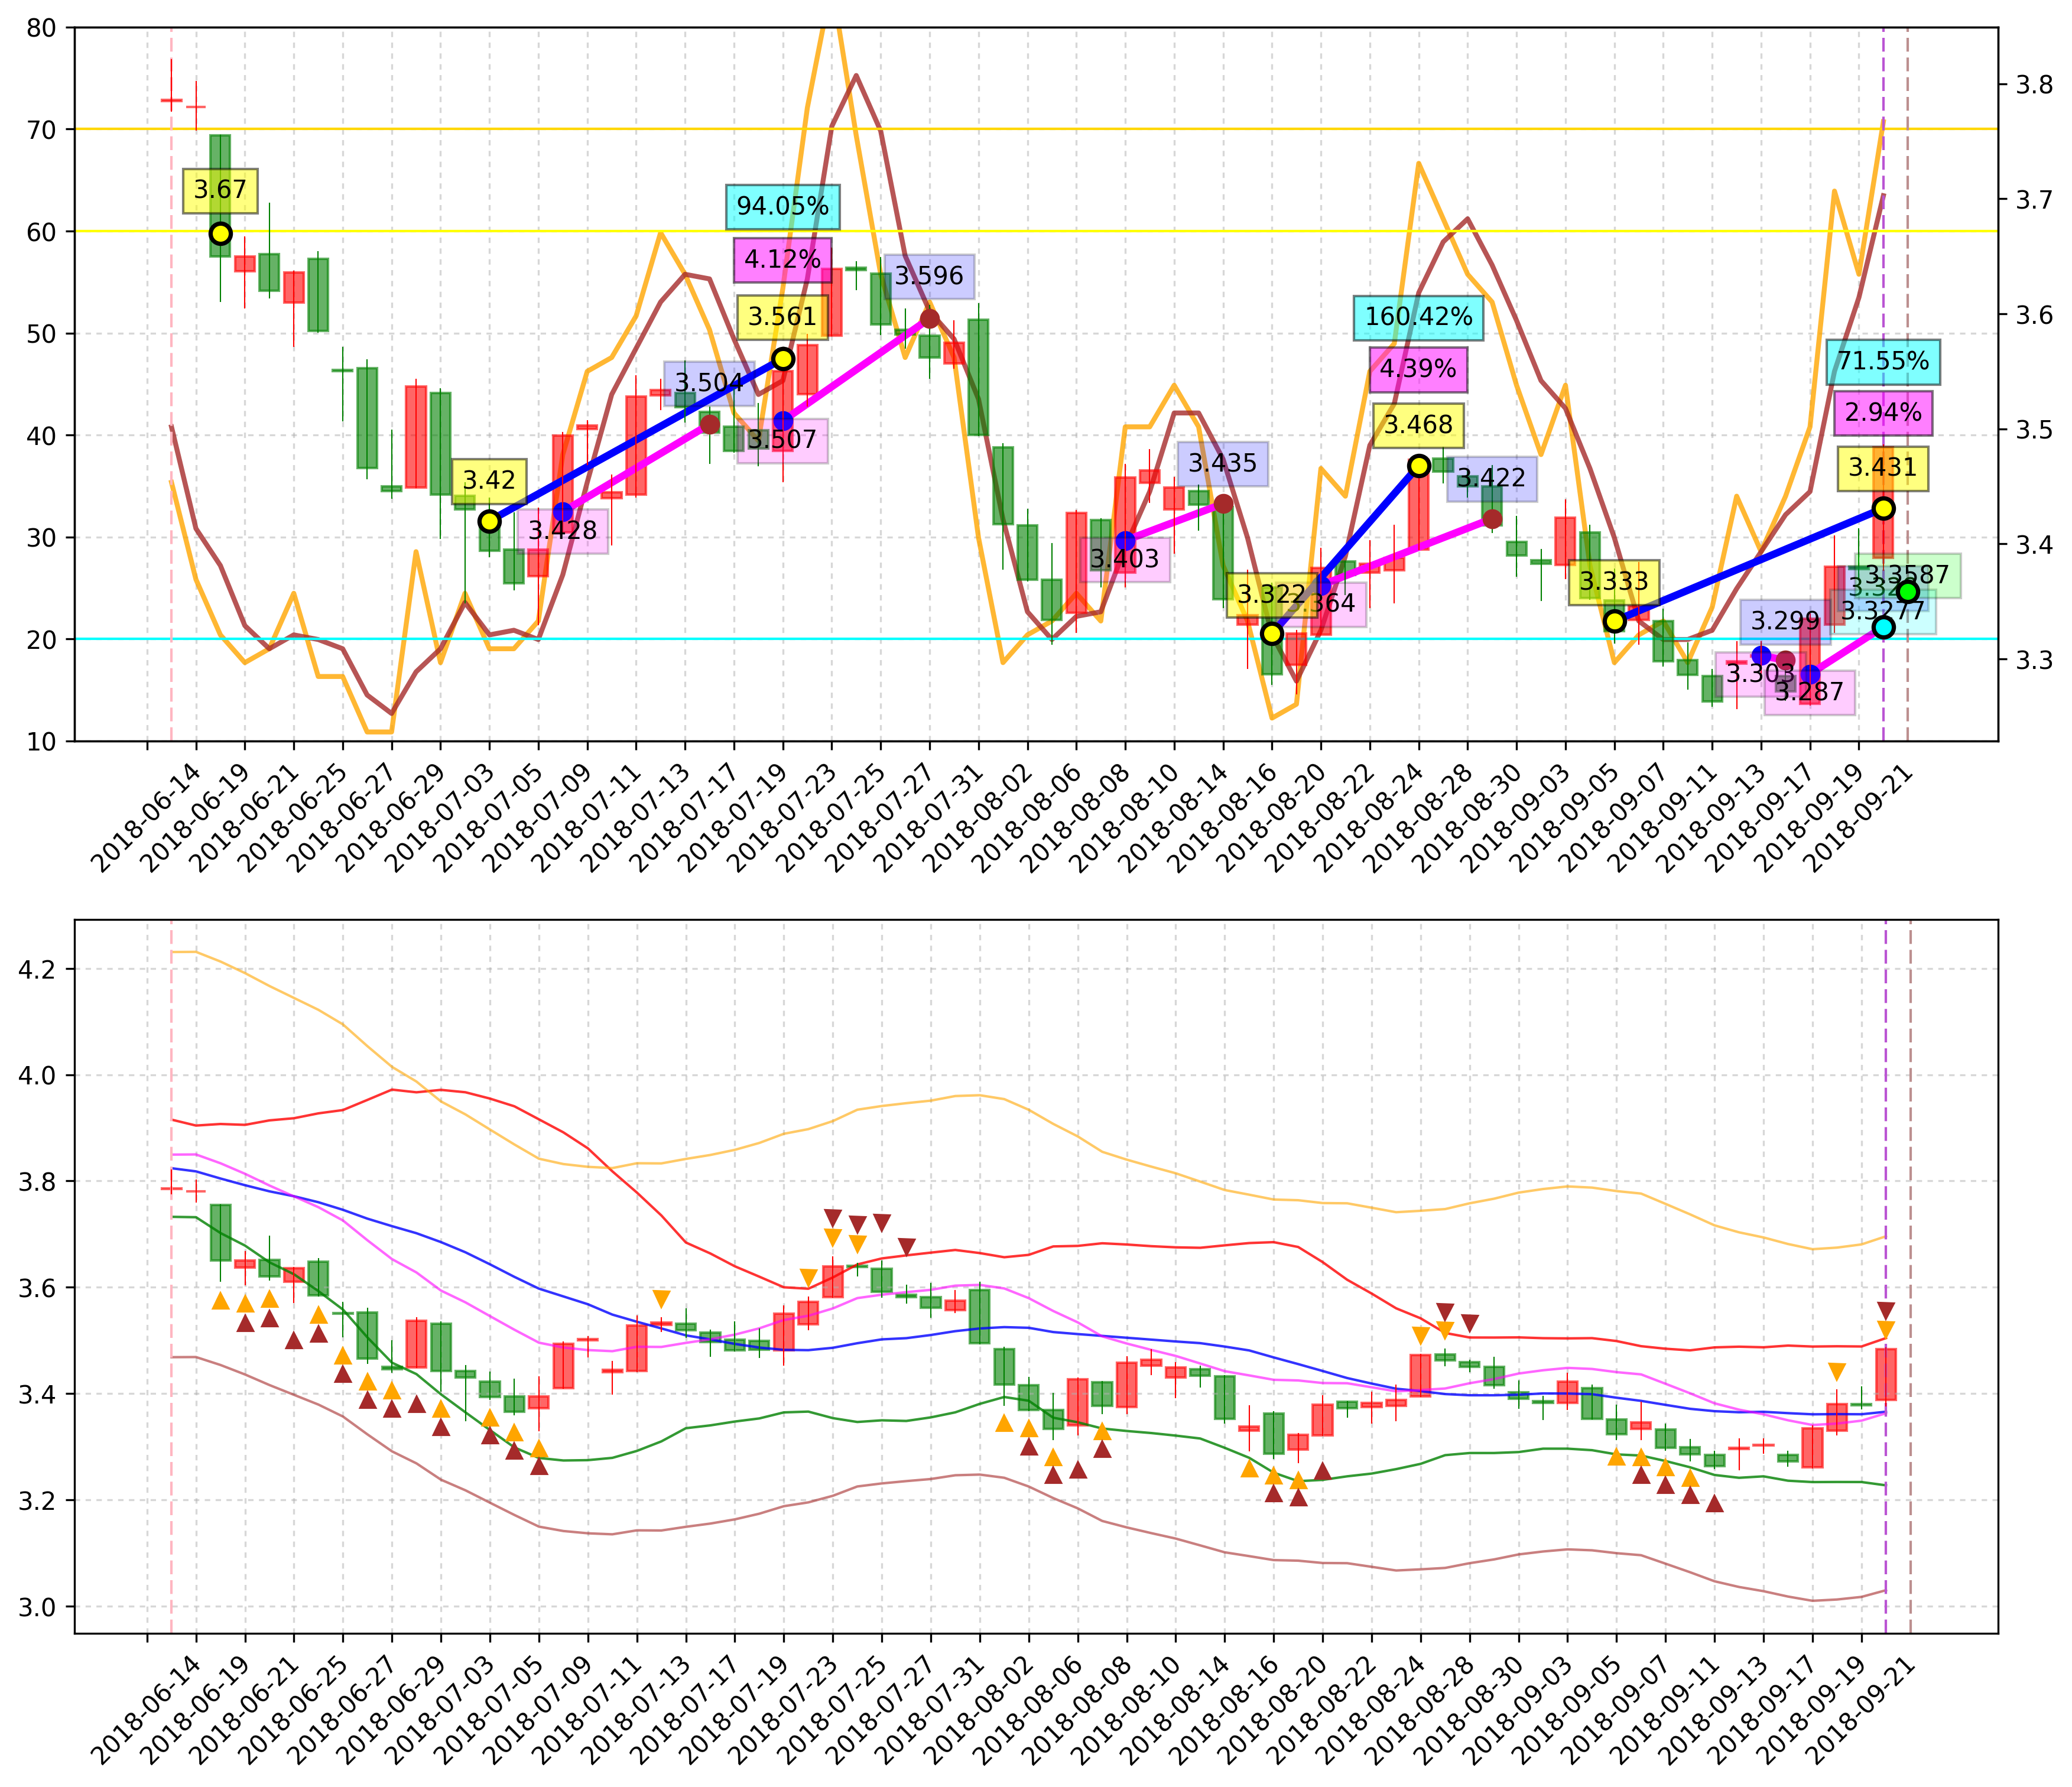

In [65]:
plt.show()

In [66]:
#关闭连接
ts.close_apis(cons)